#  SBCM 2021
### 18th Brazilian Symposium on Computer Music

## Introduction to Music Information Retrieval

#### [Martín Rocamora](https://iie.fing.edu.uy/~rocamora/)

### About the workshop

This notebook is part of a workshop held in the context of the [SBCM 2021](https://compmus.org.br/2021/) that provides a brief overview of the field of [Music Information Retrieval](https://en.wikipedia.org/wiki/Music_information_retrieval) (MIR), the interdisciplinary science of retrieving information from music.

The workshop covers some selected topics in MIR, such as audio similarity, pitch tracking, and rhythm analysis. The signal processing and machine learning techniques involved are discussed in an approachable way through a set of lectures and interactive lab sessions. The workshop is designed for students, musicians, engineers, researchers, and data scientists who are new to MIR and want to get introduced to the field. Knowledge of basic digital audio principles and some experience with any programming language is recommended. 

### About this notebook

This notebook is intended for testing an audio to audio synchronization approach based on a chroma features and dynamic time warping. The fundamentals of the technique are discussed during the workshop lectures. Please refer to the [Fundamentals of Music Processing (FMP)](https://www.audiolabs-erlangen.de/fau/professor/mueller/bookFMP) book (in particular Chapter 3) for further information and a complete explanation. 

Thi notebook is based on the [SyncAudioAudioSimple](https://github.com/meinardmueller/synctoolbox/blob/master/sync_audio_audio_simple.ipynb) and the [SyncAudioAudioFull](https://github.com/meinardmueller/synctoolbox/blob/master/sync_audio_audio_full.ipynb) notebooks from the [Sync Toolboox](https://github.com/meinardmueller/synctoolbox) library.



### How to run the notebook

You can download the notebook and run it locally in your computer.

You can also run it in Google Colab by using the following link. 

<table align="center">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/mrocamora/mir_workshop/blob/main/notebooks/MIR_workshop_audio_synchronization.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

Or you can run them using Binder directly in your browser: [![Binder](https://mybinder.org/badge_logo.svg)](https://notebooks.gesis.org/binder/v2/gh/mrocamora/mir_workshop/blob/main/notebooks/MIR_workshop_audio_synchronization.ipynb)


In [ ]:
!pip install librosa

In [ ]:
!pip install libfmp

In [ ]:
!pip install synctoolbox

In [ ]:
!pip install libtsm

#### Import required packages

In [1]:
import numpy as np
import pandas as pd
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import scipy.interpolate
from libfmp.b.b_plot import plot_signal, plot_chromagram
from libfmp.c3.c3s2_dtw_plot import plot_matrix_with_points

import libtsm
from synctoolbox.dtw.mrmsdtw import sync_via_mrmsdtw
from synctoolbox.dtw.utils import make_path_strictly_monotonic
from synctoolbox.feature.chroma import pitch_to_chroma, quantize_chroma, quantized_chroma_to_CENS
from synctoolbox.feature.pitch import audio_to_pitch_features

%matplotlib inline

#### Define some constants

In [2]:
Fs = 22050
feature_rate = 50
step_weights = np.array([1.5, 1.5, 2.0])
threshold_rec = 10 ** 6

figsize = (9, 3)

#### Download audio files
Download audio files to work with.

In [ ]:
!wget https://iie.fing.edu.uy/~rocamora/downloads/tmp/audio.zip
!unzip audio.zip

### 1) Load two recordings of the same music fragment

Now we have to load two audio recordings of the same music fragment. 

Among the audio files available there are two recordings of a short fragment of the tango called  ["El garrón"](https://www.youtube.com/watch?v=D_zReeR7cBI) played by a guitar quartet. Notice that they actually played at a different tempo and a different variation of the musical phrase.

There are also two recordings of a short music tune from the song ["Dedos"](https://www.youtube.com/watch?v=LIigNgZTy7Q) by [Rubén Rada](https://en.wikipedia.org/wiki/Rub%C3%A9n_Rada) played by two different instruments (a melodica and a guitar).

Besides, there are two recordings of a short riff from the song ["Sir Duke"](https://en.wikipedia.org/wiki/Sir_Duke) by Stevie Wonder. The first one is played at a slower tempo compared to second one.

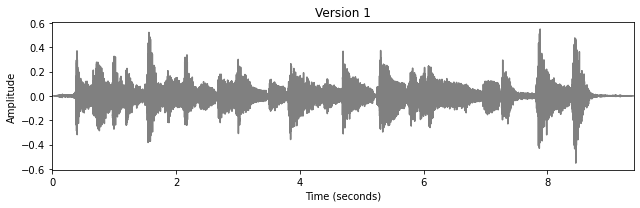

In [41]:
audio_1, _ = librosa.load('audio/el_garron_1.wav', Fs)
# audio_1, _ = librosa.load('audio/dedos_melodica.wav', Fs)
#audio_1, _ = librosa.load('audio/sir_duke_slow.wav', Fs)

plot_signal(audio_1, Fs=Fs, ylabel='Amplitude', title='Version 1', figsize=figsize)
ipd.display(ipd.Audio(audio_1, rate=Fs))

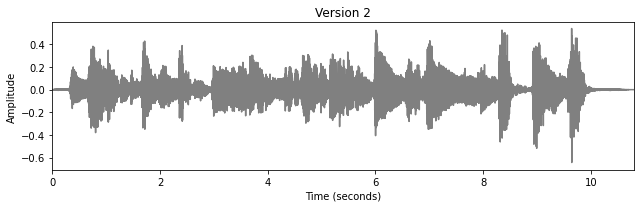

In [42]:
audio_2, _ = librosa.load('audio/el_garron_2.wav', Fs)
#audio_2, _ = librosa.load('audio/dedos_guitar.wav', Fs)
#audio_2, _ = librosa.load('audio/sir_duke_fast.wav', Fs)

plot_signal(audio_2, Fs=Fs, ylabel='Amplitude', title='Version 2', figsize=figsize)
ipd.display(ipd.Audio(audio_2, rate=Fs))

Listen to the two recordings toghether to verify they are not synchronized.

In [43]:
ml = np.min([len(audio_1), len(audio_2)])
audio_1_s = audio_1[:ml]
audio_2_s = audio_2[:ml]
audio_stereo = np.hstack((audio_2_s.reshape(-1, 1), audio_1_s.reshape(-1, 1)))

print('Not synchronized versions', flush=True)
ipd.display(ipd.Audio(audio_stereo.T, rate=Fs, normalize=True))

Not synchronized versions


### 2) Compute chroma representations

We calculate two quantized chroma features derived from STFTs. 

In [44]:
def get_features_from_audio(audio, visualize=True):
    f_pitch = audio_to_pitch_features(f_audio=audio, Fs=Fs, feature_rate=feature_rate)
    f_chroma = pitch_to_chroma(f_pitch=f_pitch)
    f_chroma_quantized = quantize_chroma(f_chroma=f_chroma)

    return f_chroma_quantized


f_chroma_quantized_1 = get_features_from_audio(audio_1)
f_chroma_quantized_2 = get_features_from_audio(audio_2)

................................................................................................................................................................................

The next plots illustrate the chroma featuers of each version.

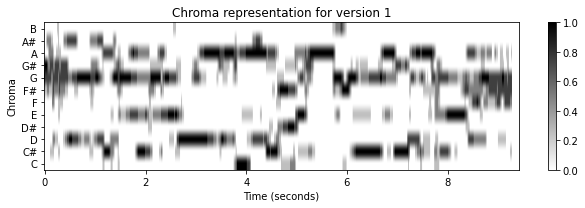

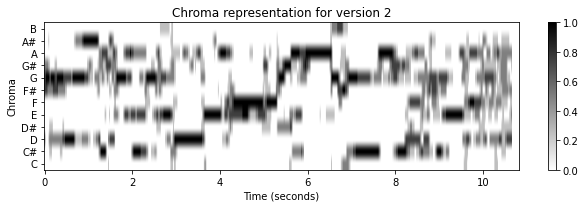

In [45]:
plot_chromagram(f_chroma_quantized_1, Fs=feature_rate, title='Chroma representation for version 1', figsize=figsize)
plt.show()

plot_chromagram(f_chroma_quantized_2, Fs=feature_rate, title='Chroma representation for version 2', figsize=figsize)
plt.show()

### 3) Align chroma representations using Dynamic Time Warping

The chroma feature sequences in the last cell look quite similar and can be used for time aligning. In the next cell we use the SyncToolbox implementation of DTW to do this. Note that a multi-resolution multi-scale DTW (MrMsDTW) is actually used. Please refer to the original [SyncAudioAudioFull](https://github.com/meinardmueller/synctoolbox/blob/master/sync_audio_audio_full.ipynb) notebook and the references therein for further information.  

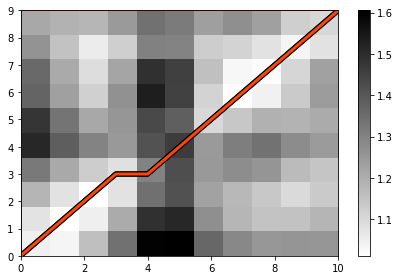

Level 0 computation time: 0.00 seconds


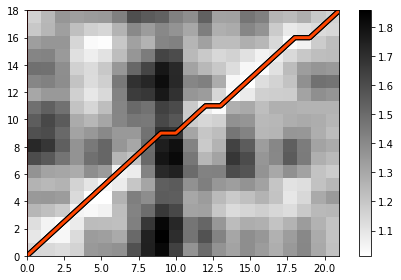

Level 1 computation time: 0.00 seconds


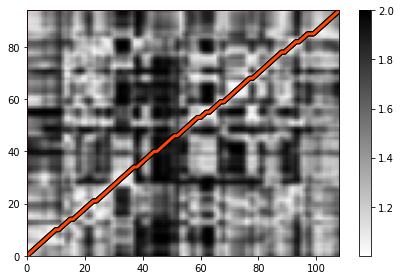

Level 2 computation time: 0.00 seconds


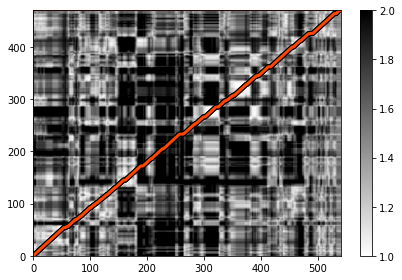

Level 3 computation time: 0.03 seconds
Computation time of MrMsDTW: 0.03 seconds


In [46]:
wp = sync_via_mrmsdtw(f_chroma1=f_chroma_quantized_1, f_chroma2=f_chroma_quantized_2, input_feature_rate=feature_rate, step_weights=step_weights, threshold_rec=threshold_rec, verbose=True)

### 4) Sonification of the alignment

In order to listen to the synchronization result, version 1 will now be time-scaled (according to the computed warping path) to run synchronous to version 2. 

For the time-scale modification, we use the [libtsm](https://github.com/meinardmueller/libtsm) library. The result is sonified by putting the warped version 1 into the left channel and version 2 into the right channel of a stereo audio file.

The standard step sizes used in DTW allow for horizontal and vertical steps, which leads to warping paths that are not guaranteed to be strictly monotonous. This is usually not a problem. However, for some applications it may be better to use a strictly monotonous path and employ linear interpolation inside non-monotonous segments.

In [47]:
print('Length of warping path obtained from MrMsDTW:', wp.shape[1])
wp = make_path_strictly_monotonic(wp)
print('Length of warping path made strictly monotonic:', wp.shape[1])

Length of warping path obtained from MrMsDTW: 541
Length of warping path made strictly monotonic: 471


In [48]:
# The TSM functionality of the libtsm library expects the warping path to be given in audio samples.
# Here, we do the conversion and additionally clip values that are too large.
time_map = wp.T / feature_rate * Fs
time_map[time_map[:, 0] > len(audio_1), 0] = len(audio_1) - 1 
time_map[time_map[:, 1] > len(audio_2), 1] = len(audio_2) - 1

#y_hpstsm = libtsm.hps_tsm(audio_1_shifted, time_map)
y_hpstsm = libtsm.hps_tsm(audio_1, time_map)
stereo_sonification = np.hstack((audio_2.reshape(-1, 1), y_hpstsm))

print('Original signal 1', flush=True)
ipd.display(ipd.Audio(audio_1, rate=Fs, normalize=True))

print('Original signal 2', flush=True)
ipd.display(ipd.Audio(audio_2, rate=Fs, normalize=True))

print('Not synchronized versions', flush=True)
ipd.display(ipd.Audio(audio_stereo.T, rate=Fs, normalize=True))

print('Synchronized versions', flush=True)
ipd.display(ipd.Audio(stereo_sonification.T, rate=Fs, normalize=True))

Original signal 1


Original signal 2


Not synchronized versions


Synchronized versions


## Proposed activity

Now that you have gone through a complete example you could try to used other recordings, either the other ones provided above or some new ones.

  * What difficulties you think you should face in a real application? Do you have any ideas on how to deal with them?
  * How would you address the synchronization of audio to MIDI?

## Concluding remarks

Notice that we have just scratched the surface of the music synchronization task. There several other important steps involved in doing a proper alignment, for instance related to dealing with cases in which the performances of same piece are played in different keys.

For those of you interested in going deeper the [Fundamentals of Music Processing (FMP)](https://www.audiolabs-erlangen.de/fau/professor/mueller/bookFMP) book (in particular Chapter 3) as well as the corresponding [FMP notebooks](https://www.audiolabs-erlangen.de/resources/MIR/FMP) are highly recommended.
